# Categorical Variational Autoencoder with Transformer and Gumbel-Softmax

## Necessary Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

## Transformer Module

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention, _ = self.attention(value, key, query, attn_mask=mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Transformer(nn.Module):
    def __init__(self, embed_size, heads, num_layers, dropout, forward_expansion):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size, heads, dropout, forward_expansion
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, value, key, query, mask):
        for layer in self.layers:
            query = layer(value, key, query, mask)
        return query


## Encoder Module

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_size, heads, num_layers, dropout, forward_expansion, latent_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_size)
        self.transformer = Transformer(embed_size, heads, num_layers, dropout, forward_expansion)
        self.fc_mu = nn.Linear(embed_size, latent_dim)
        self.fc_logvar = nn.Linear(embed_size, latent_dim)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.transformer(x, x, x, mask)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var


## Decoder for Categorical VAE

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, embed_size, heads, num_layers, dropout, forward_expansion, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, embed_size)
        self.transformer = Transformer(embed_size, heads, num_layers, dropout, forward_expansion)
        self.out = nn.Linear(embed_size, output_dim)

    def forward(self, x, mask=None):
        x = self.fc(x)
        x = self.transformer(x, x, x, mask)
        return self.out(x)



## Categorical VAE with Gumbel-Softmax Reparameterization

In [6]:
class TCVAE(nn.Module):
    def __init__(
        self, 
        input_dim, 
        embed_size, 
        heads, 
        num_layers, 
        dropout, 
        forward_expansion, 
        latent_dim,
        num_categories
    ):
        super(TCVAE, self).__init__()
        self.encoder = Encoder(input_dim, embed_size, heads, num_layers, dropout, forward_expansion, latent_dim)
        self.decoder = Decoder(latent_dim, embed_size, heads, num_layers, dropout, forward_expansion, output_dim=input_dim)
        self.num_categories = num_categories
        self.num_pixels = input_dim  # 784 for MNIST
        self.beta = 0.0  # beta-VAE parameter

    # def reparameterize(self, logits, temperature=1.0):
    #     return F.gumbel_softmax(logits, tau=temperature, hard=False, dim=-1)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, mask=None, temperature=1.0):
        mu, log_var = self.encoder(x, mask)
        # z = self.reparameterize(mu, temperature)  # Use Gumbel-Softmax for reparameterization
        z = self.reparameterize(mu, log_var)
        logits = self.decoder(z, mask) # shape of logits (should be): [batch_size, sequence_length, num_categories]
        return logits, mu, log_var

    def loss_function(self, x, logits, mu, log_var):
        # Normalize the data to [0, 1] range and ensure it's float
        x_normalized = x.float()
        # recon_loss = F.cross_entropy(logits.view(-1), x_normalized.view(-1), reduction='sum')
        # Use BCEWithLogitsLoss 
        recon_loss = F.binary_cross_entropy_with_logits(logits, x_normalized, reduction='sum')
        
        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        return recon_loss + self.beta * kld_loss, recon_loss, kld_loss

# Train

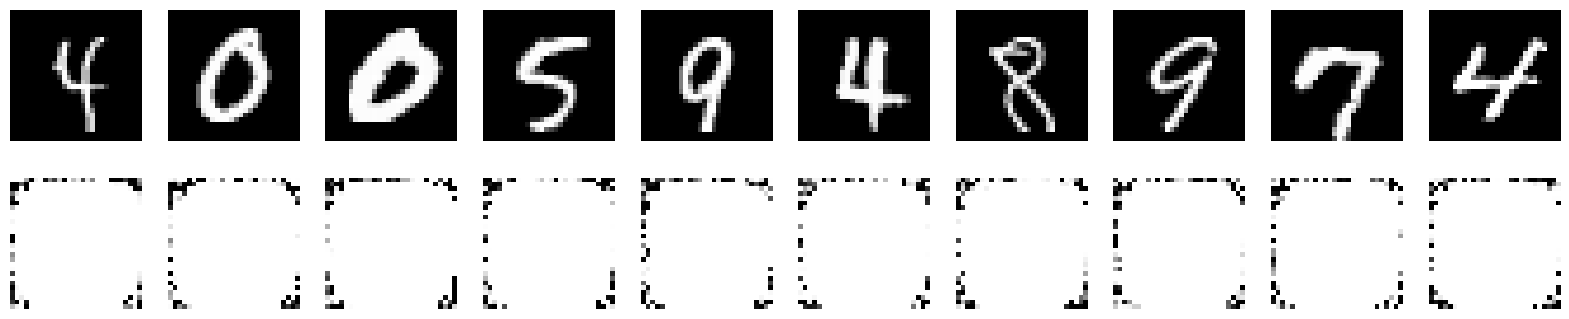

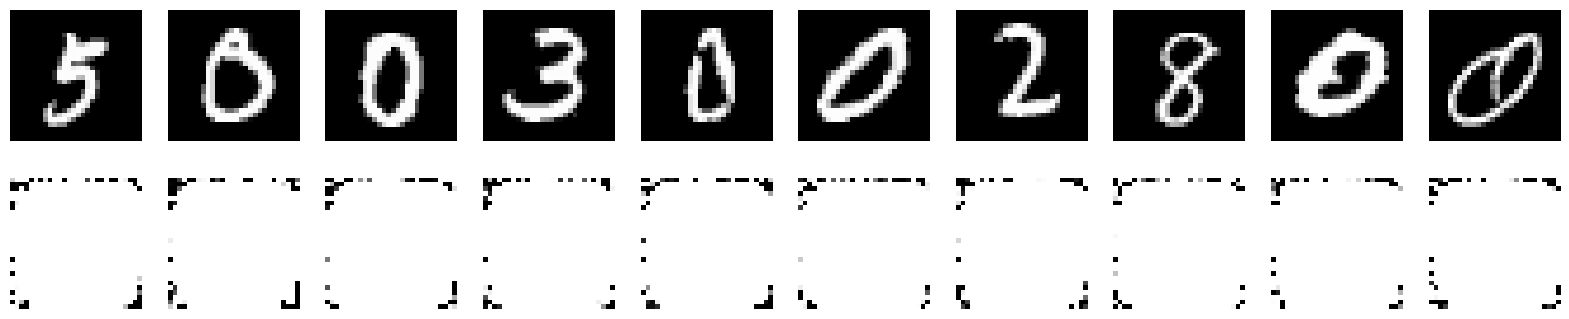

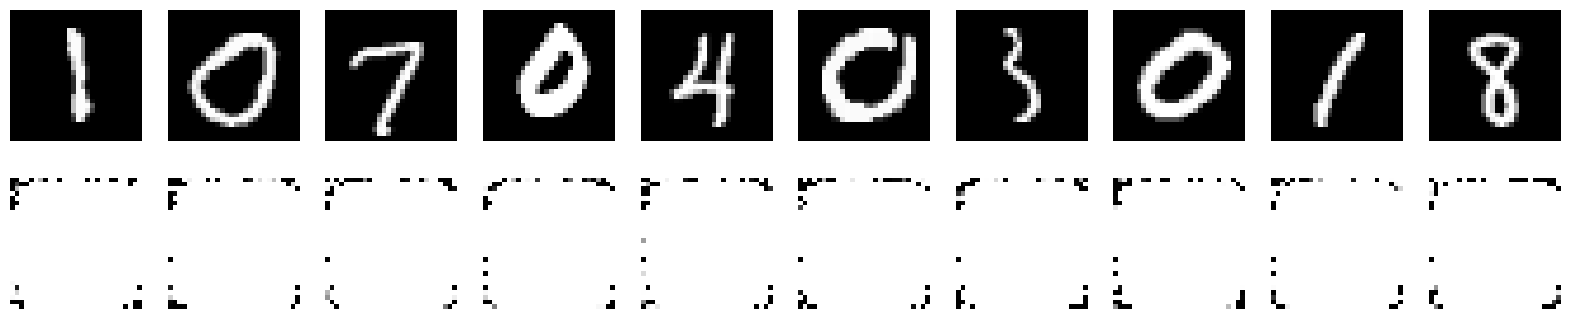

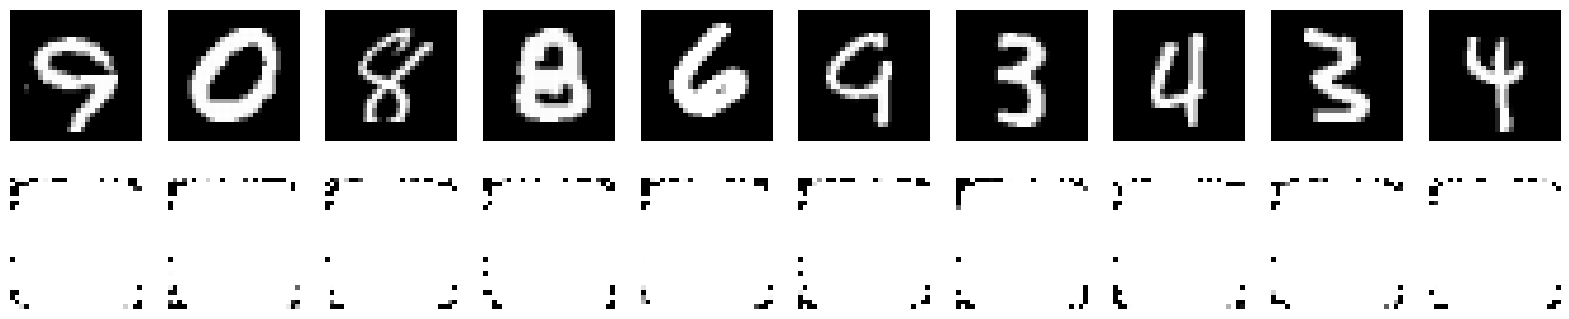

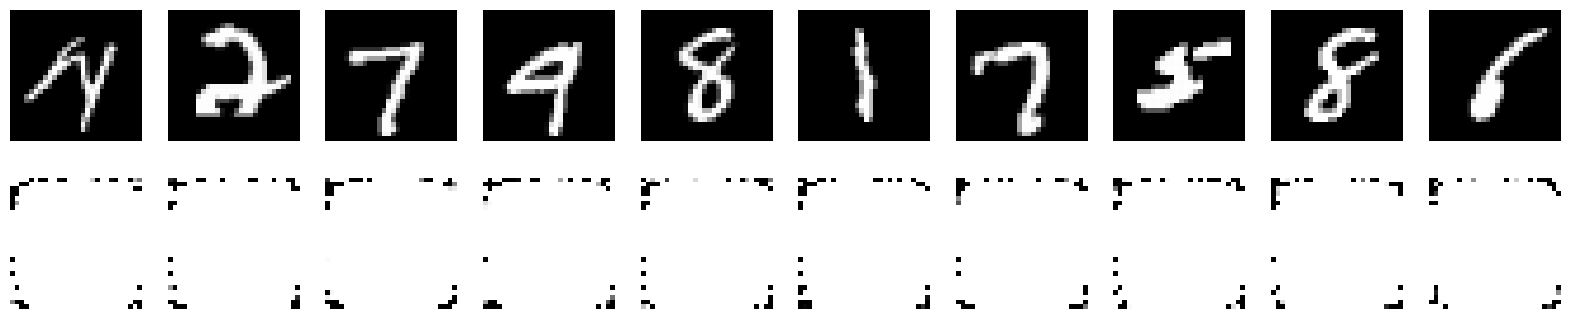

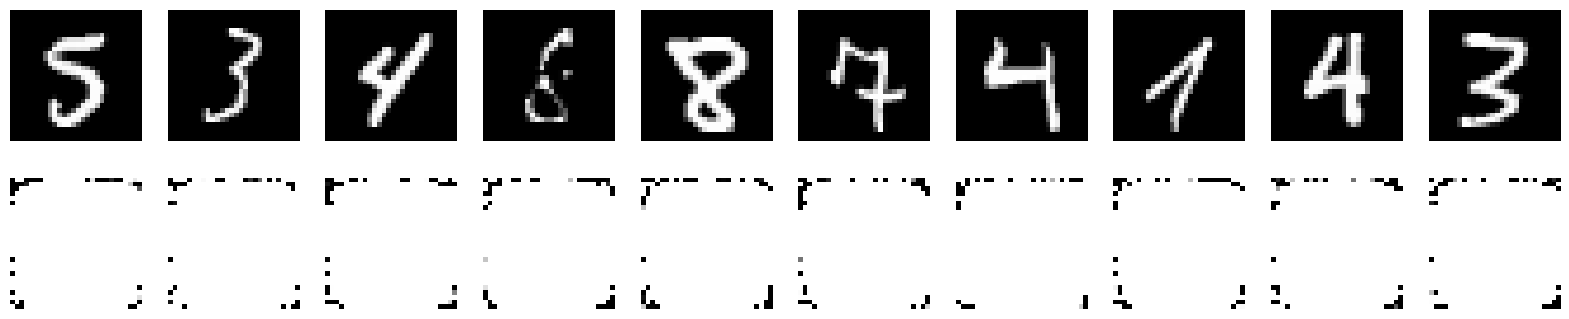

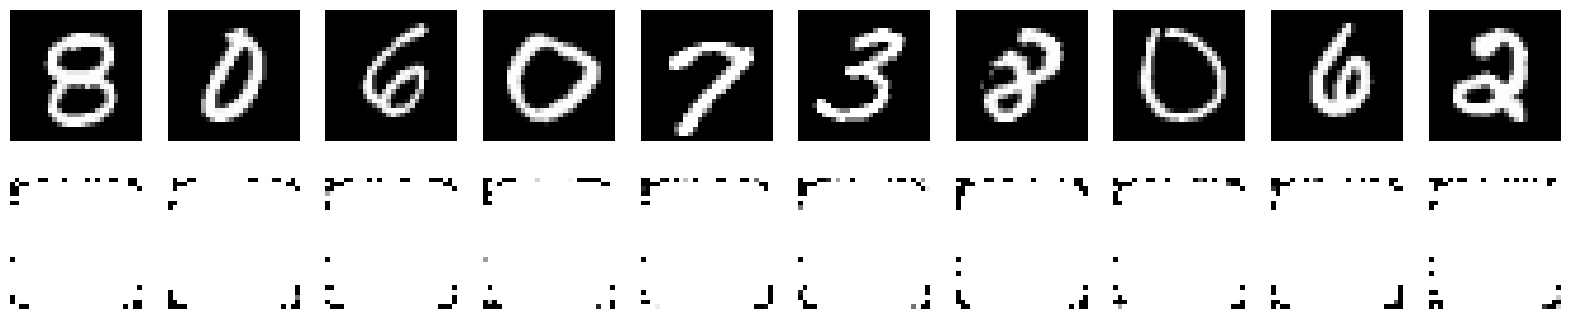

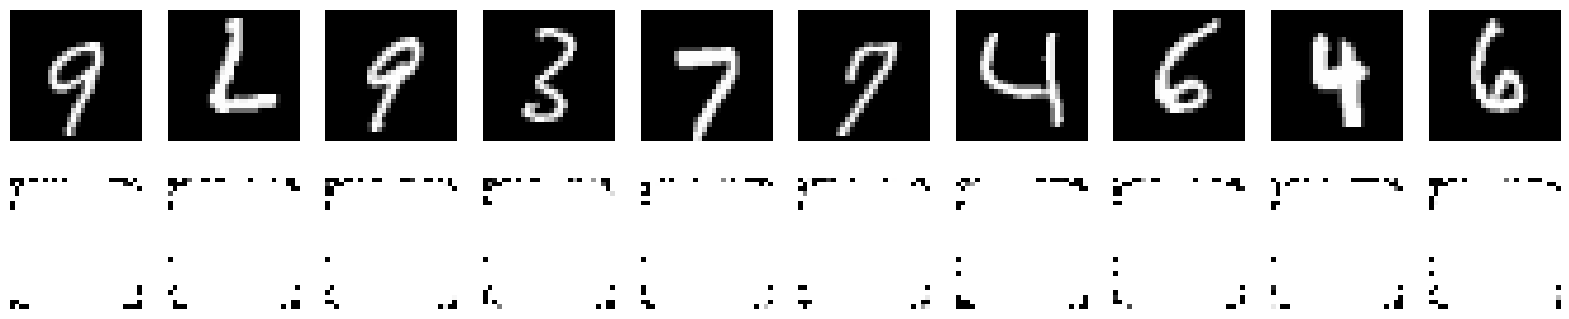

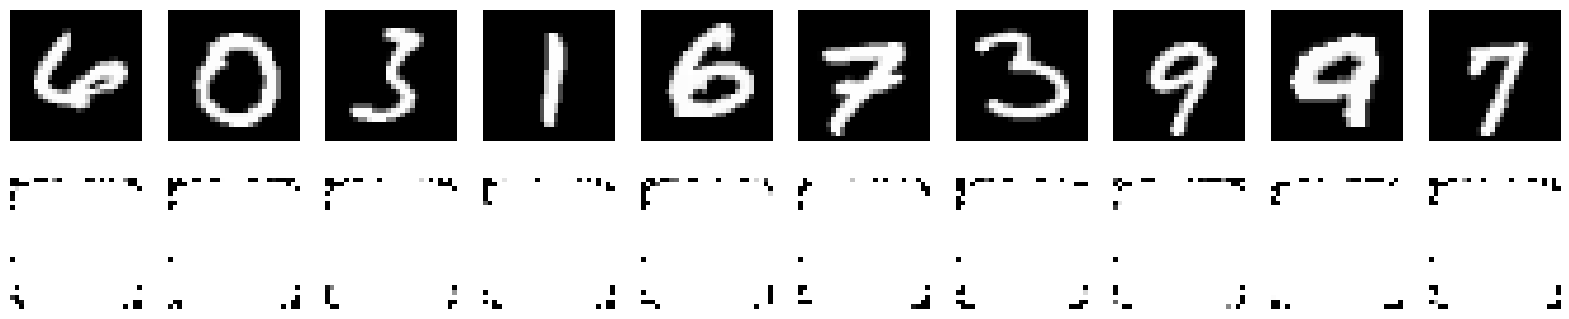

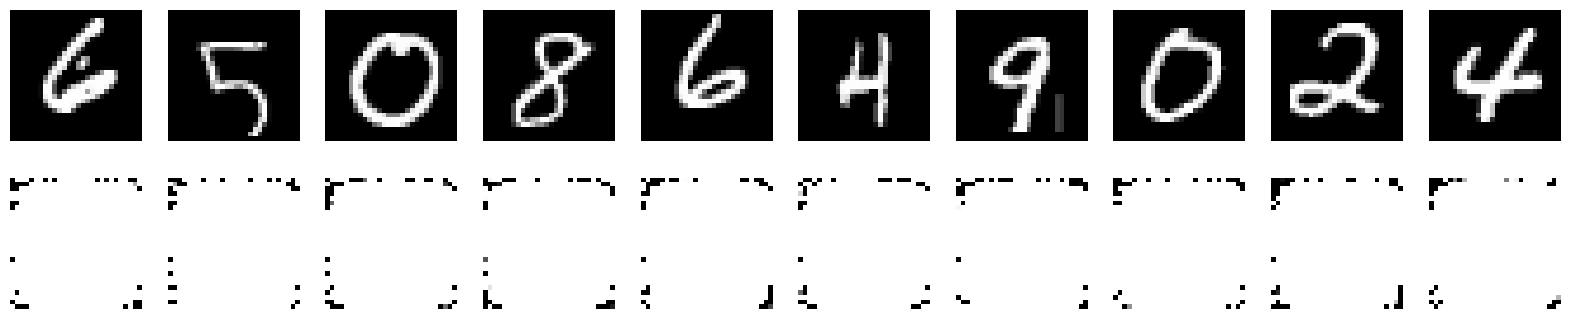

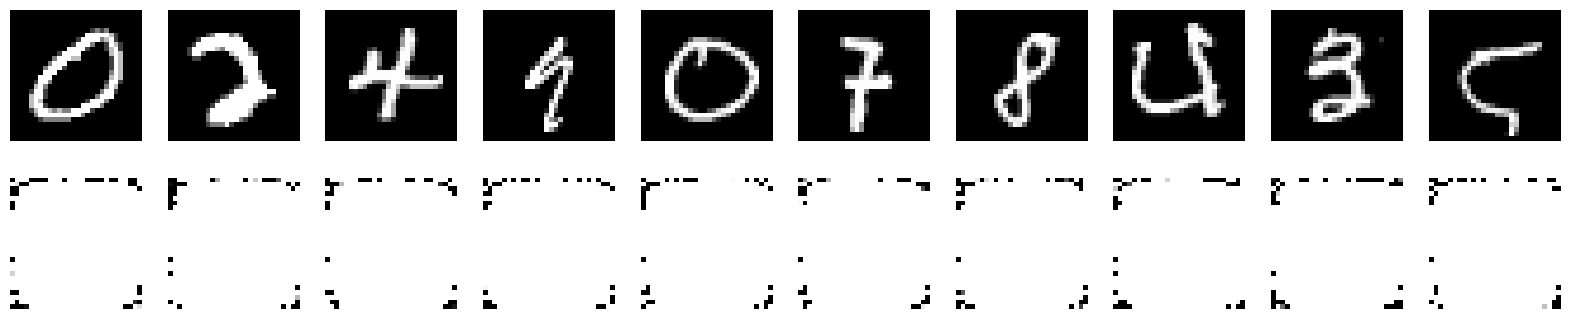

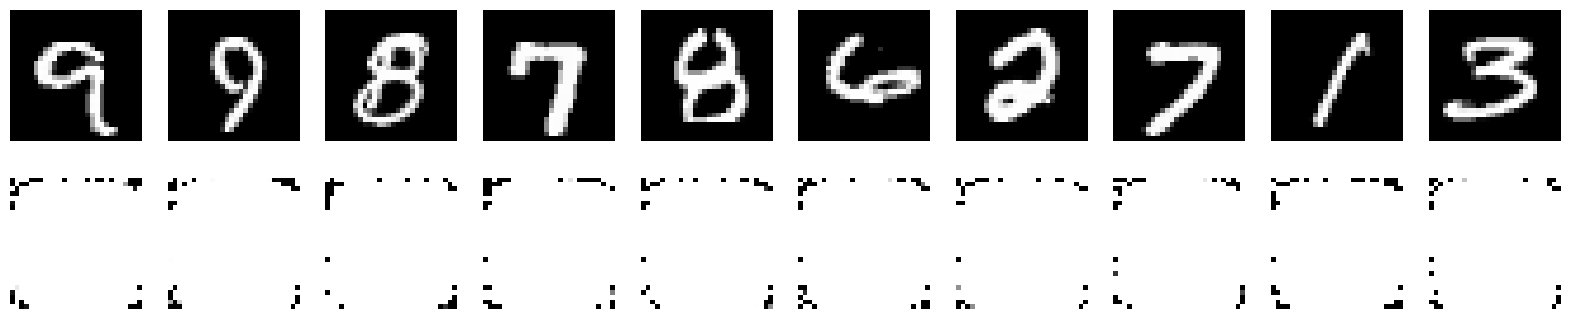

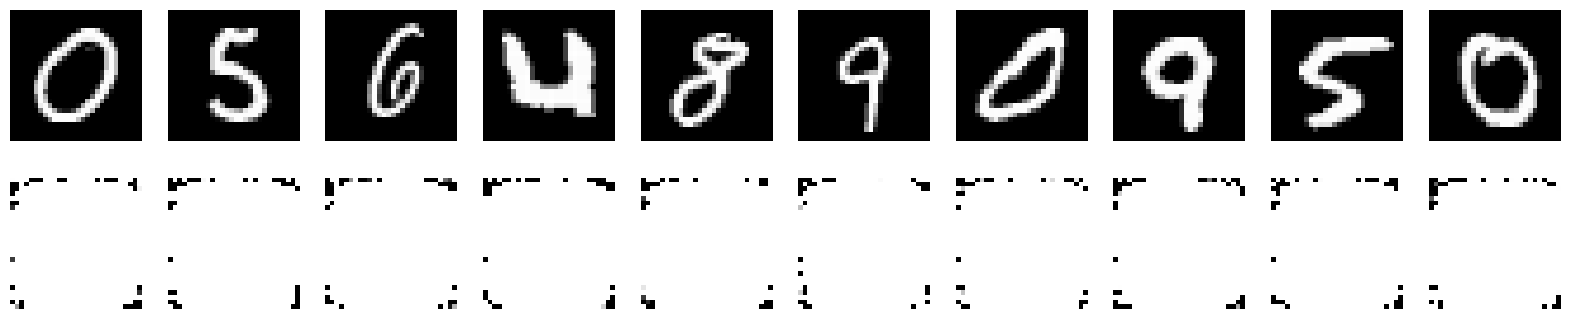

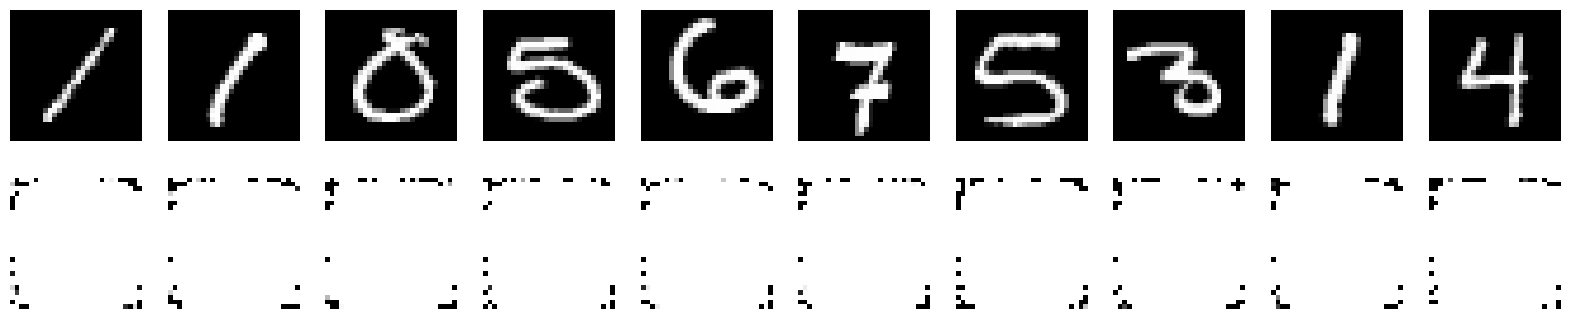

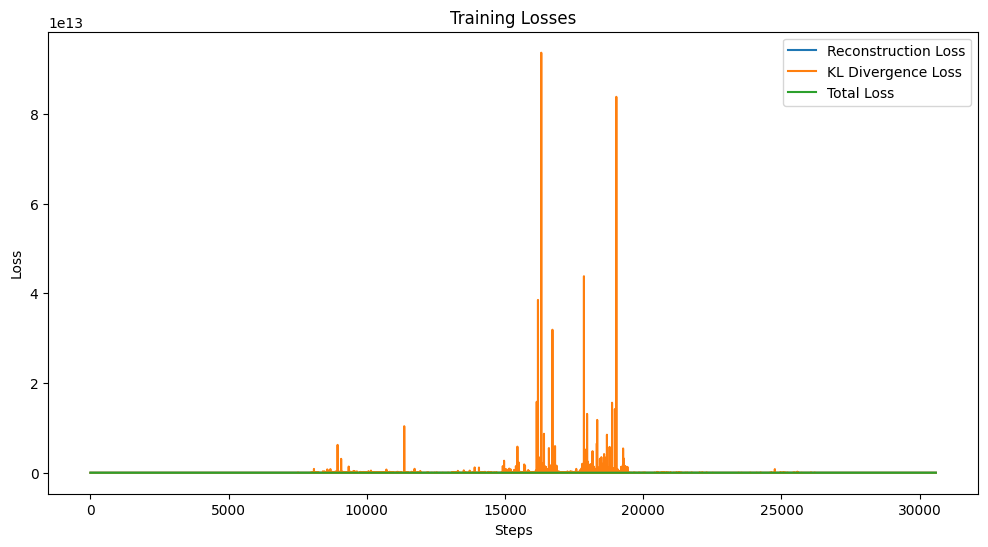

In [7]:
from torch.optim import AdamW
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(
    epochs=10,
    batch_size=32,
    learning_rate=1e-5,
    embed_size=32,
    heads=1,
    num_layers=1,
    dropout=0.3,
    forward_expansion=1,
    latent_dim=20,
    num_categories=10
):
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model and optimizer
    model = TCVAE(
        input_dim=784, 
        embed_size=embed_size, 
        heads=heads, 
        num_layers=num_layers, 
        dropout=dropout, 
        forward_expansion=forward_expansion, 
        latent_dim=latent_dim, 
        num_categories=num_categories
    )
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Move model to appropriate device
    model.to(device)

    # Lists to store losses
    recon_losses = []
    kld_losses = []
    total_losses = []

    def weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    model.apply(weights_init)


    # Outer loop for epochs
    for epoch in range(epochs):
        model.train()
        
        # Training loop with tqdm progress bar for batches
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for data, _ in pbar:
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            logits, mu, log_var = model(data)

            # Calculate losses
            total_loss, recon_loss, kld_loss = model.loss_function(logits, data, mu, log_var)
            total_loss.backward()

            recon_losses.append(recon_loss.item())
            kld_losses.append(kld_loss.item())
            total_losses.append(total_loss.item())

            optimizer.step()
            
            # Update tqdm progress bar description for batches
            pbar.set_postfix({"Batch Loss": total_loss.item() / len(data)})

        # 每隔几个epochs或在开始时检查模型的输出
        if epoch % 2 == 0:
            # 选择一批样本
            sample_data, _ = next(iter(train_loader))
            sample_data = sample_data.view(sample_data.size(0), -1).to(device)

            # 获取模型的输出
            with torch.no_grad():
                logits, _, _ = model(sample_data)
                reconstructed = torch.sigmoid(logits).cpu().numpy()

            # 可视化原始和重构的样本
            fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
            for i in range(10):
                # 原始样本
                axes[0, i].imshow(sample_data[i].cpu().reshape(28, 28), cmap='gray')
                axes[0, i].axis('off')
                
                # 重构的样本
                axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
                axes[1, i].axis('off')
            
            plt.show()

    # Plot the losses
    plt.figure(figsize=(12, 6))
    plt.plot(recon_losses, label="Reconstruction Loss")
    plt.plot(kld_losses, label="KL Divergence Loss")
    plt.plot(total_losses, label="Total Loss")
    plt.title("Training Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

# Quick training test
# model = train(epochs=10)

# Trial 5, Validation Loss: 138.6107454341939
#     learning_rate: 0.0004667460969903011
#     embed_size: 256
#     heads: 32
#     num_layers: 1
#     dropout: 0.6747343356856723
#     forward_expansion: 1
#     latent_dim: 29
#     batch_size: 53
#     epochs: 27
model = train(learning_rate=0.0004667, 
              embed_size=256,
              heads=32,
              num_layers=1,
              dropout=0.6747343,
              forward_expansion=1,
              latent_dim=29,
              batch_size=53,
              epochs=27)

In [8]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# 2. Classify data by labels
classified_data = {i: [] for i in range(10)}
for data, labels in mnist_loader:
    for i in range(10):
        indices = (labels == i).nonzero().squeeze()
        classified_data[i].extend(data[indices])

# 3. Select 10 samples from each class
selected_samples = {i: [] for i in range(10)}
for i in range(10):
    selected_samples[i] = classified_data[i][:10]


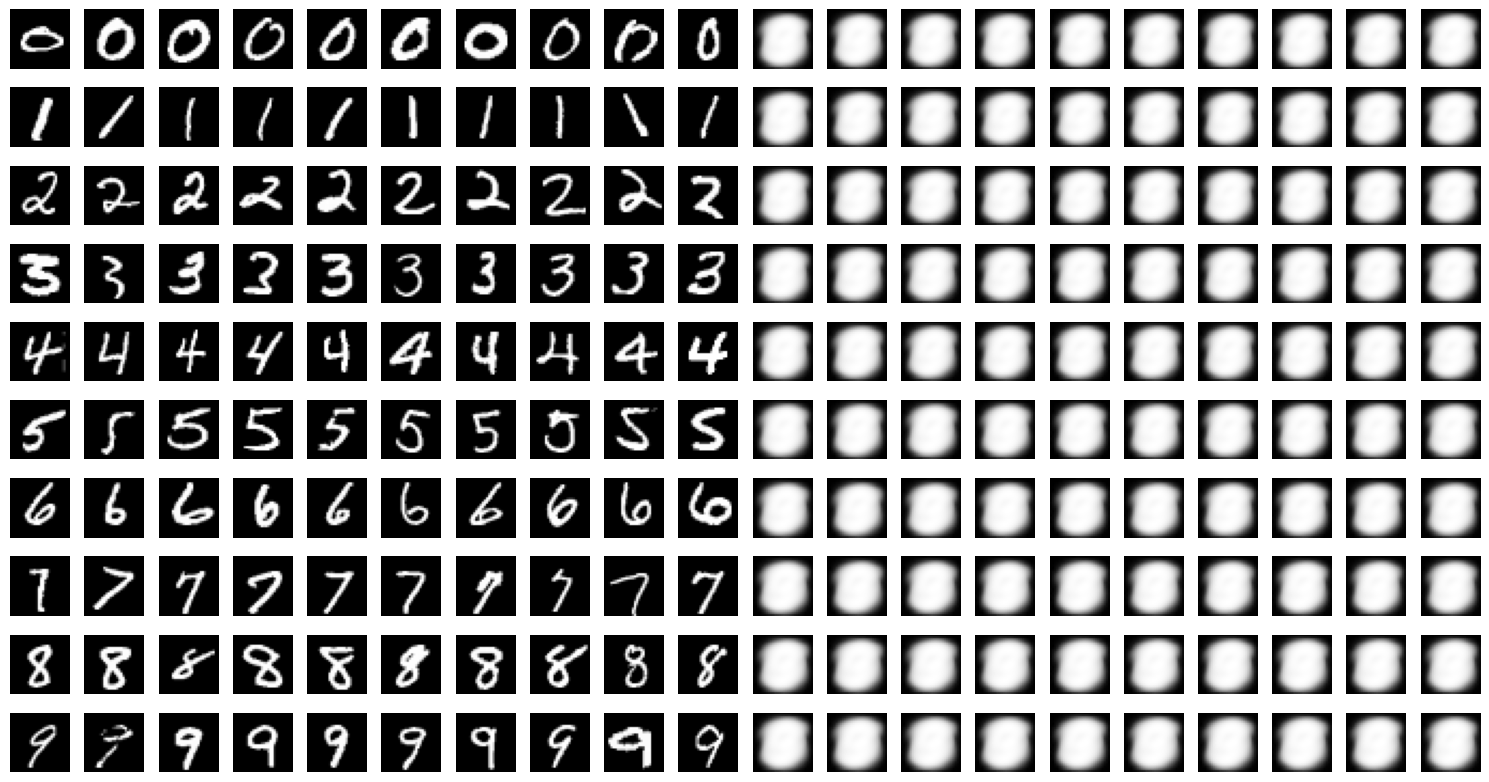

In [9]:
# 4. Model Inference
reconstructed_samples = {i: [] for i in range(10)}
model.eval()
with torch.no_grad():
    for i in range(10):
        inputs = torch.stack(selected_samples[i]).view(-1, 28*28).to(device)  # Reshaping the input here
        logits, _, _ = model(inputs)
        # reconstructed = torch.sigmoid(logits)  # Convert logits to probabilities
        reconstructed_samples[i] = logits.cpu().view(-1, 28, 28)  # Reshaping the output for visualization

# 5. Compact Visualization
fig, axes = plt.subplots(10, 20, figsize=(15, 8))  # 10 classes, 20 images per class (10 original + 10 reconstructed)

for i in range(10):
    # Original images
    for j, img in enumerate(selected_samples[i]):
        axes[i][j].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i][j].axis('off')
    
    # Reconstructed images
    for j, img in enumerate(reconstructed_samples[i]):
        axes[i][j+10].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i][j+10].axis('off')

plt.tight_layout()
plt.show()



## Conclusion

The notebook presents the construction of a Categorical Variational Autoencoder (CatVAE) using Transformers and Gumbel-Softmax for reparameterization. The model is designed to handle categorical data by outputting probabilities for each category and using a cross-entropy loss for reconstruction.